## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jun 13 07:00:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [3]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kid0ta8n
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kid0ta8n
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=56c8cb3807ec5e23486fc6797675cf47455b7a9410e30bbd6be3ba8cf4f00ac9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ut_2laij/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.2 MB/s eta 0:00:00


### Download SAM weights

In [5]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [7]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [8]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [9]:
mask_generator = SamAutomaticMaskGenerator(sam)

## Segment Anything in Roboflow Universe Dataset

### Utils Supporting Dataset Processing

A couple of helper functions that, unfortunately, we have to write ourselves to facilitate the processing of COCO annotations.

In [10]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

### Download Dataset from Roboflow

In [11]:
%cd {HOME}

import roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="tuwFjeqNliiK9NYPZrr8")
project = rf.workspace("ruhad").project("brain_tumer")
dataset = project.version(1).download("coco-segmentation")


/content
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Brain_tumer-1 in coco-segmentation:: 100%|██████████| 887/887 [00:00<00:00, 4844.21it/s]


In [12]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [13]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [14]:
CLASSES

['Tumer', 'tumor']

### Single Image Bounding Box to Mask

In [15]:
# set random seed to allow easy reproduction of the experiment

import random
random.seed(10)
import cv2
import supervision as sv



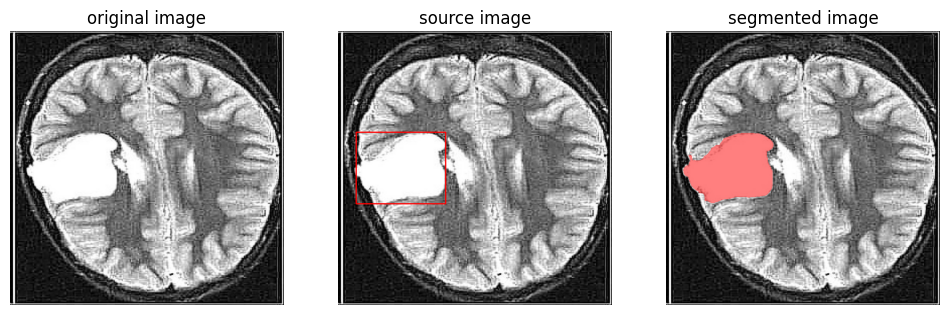

In [16]:
mask_predictor = SamPredictor(sam)

EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth, skip_label=True)

# run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_rgb, annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 3),
    titles=['original image', 'source image', 'segmented image']
)

###Metrics

Imports and Preprocessing

In [28]:
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical

#convert the image to white so it is easier to measure (lesions show up as white in the image)
mask_annotator_white = sv.MaskAnnotator(color=sv.Color.white())
annotated_image_white = mask_annotator_white.annotate(scene=image_bgr.copy(), detections=detections)

Dice

In [47]:
def dice(y_true, y_pred):
    y_truef=to_categorical(K.flatten(y_true))
    y_predf=to_categorical(K.flatten(y_pred))
    And=K.sum(y_truef* y_predf)
    dice = (2* And + 100) / (K.sum(y_truef) + K.sum(y_predf) + 100)
    return(dice)

In [48]:
print(dice(image_rgb, annotated_image_white))

tf.Tensor(0.9872442, shape=(), dtype=float32)


Jaccard

In [40]:
def jaccard(y_true, y_pred):
    y_truef=to_categorical(K.flatten(y_true))
    y_predf=to_categorical(K.flatten(y_pred))
    intersection = K.sum(y_truef * y_predf)
    sum = K.sum(y_truef + y_predf)
    jac = (intersection + 100) / (sum - intersection + 100)
    return jac

In [45]:
print(jaccard(image_rgb, annotated_image_white))

tf.Tensor(0.97481066, shape=(), dtype=float32)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.

In [ ]:
'''
@article{kirillov2023segany,
  title={Segment Anything},
  author={Kirillov, Alexander and Mintun, Eric and Ravi, Nikhila and Mao, Hanzi and Rolland, Chloe and Gustafson, Laura and Xiao, Tete and Whitehead, Spencer and Berg, Alexander C. and Lo, Wan-Yen and Doll{\'a}r, Piotr and Girshick, Ross},
  journal={arXiv:2304.02643},
  year={2023}
}
'''